In [42]:
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import xgboost

In [2]:
# Config

RANDOM_STATE = 42
TEST_SIZE = 0.2
VIF_THRESHOLD = 10.0   # more reasonable cutoff
MISSING_DROP_THRESHOLD = 0.40
WINSOR_LOWER = 0.01
WINSOR_UPPER = 0.99

INPUT_CSV = "data.csv"
DATA_DIR = "data"
OUTPUT_DIR = "artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# Load & basic cleaning
# ------------------------------
path = os.path.join(DATA_DIR, INPUT_CSV)
df = pd.read_csv(path)

# Normalize column names
df.columns = (
    df.columns.str.strip()
              .str.replace('[^A-Za-z0-9]+','_', regex=True)
              .str.lower()
)

# Convert to numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Drop sparse columns
df = df.dropna(axis=1, thresh=int((1-MISSING_DROP_THRESHOLD)*len(df)))

# Impute remaining missing with median
df = df.fillna(df.median())  # Why are we doing this?

# Winsorize outliers
for col in df.columns.drop("bankrupt_"):
    lower, upper = df[col].quantile(WINSOR_LOWER), df[col].quantile(WINSOR_UPPER)
    df[col] = np.clip(df[col], lower, upper)

(6819, 95) (6819,)
(5455, 95) (1364, 95) (5455,) (1364,)
Train accuracy: 0.742
Test accuracy: 0.733

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1313
           1       0.06      0.43      0.11        51

    accuracy                           0.73      1364
   macro avg       0.52      0.59      0.48      1364
weighted avg       0.94      0.73      0.82      1364



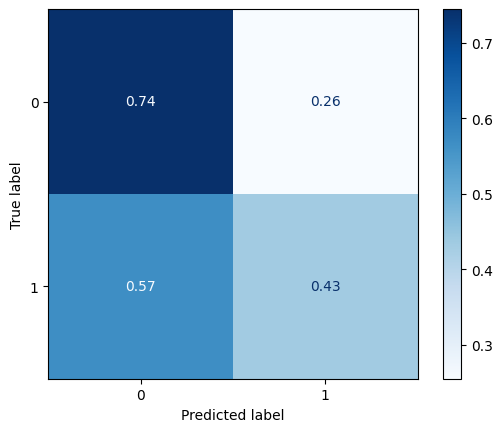

In [54]:
# Train/test split and random forest classifier
# -----------------------------------------------
X = df.loc[:, df.columns != 'bankrupt_']  # Selecting all non-sparse features
y = df['bankrupt_']  # Target is bankruptcy after given time period
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model_shap = RandomForestClassifier(  # Used for fast SHAP calculation
    n_estimators=3,
    max_depth=8,
    random_state=RANDOM_STATE
)
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)  # Baseline model on full dataset
model.fit(X_train, y_train)

print(f"Train accuracy: {model.score(X_train, y_train):.3f}")
print(f"Test accuracy: {model.score(X_test, y_test):.3f}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize by row (divide each row by the sum of that row)
cm_rates = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rates, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='.2f')  # show rates with 2 decimal places

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

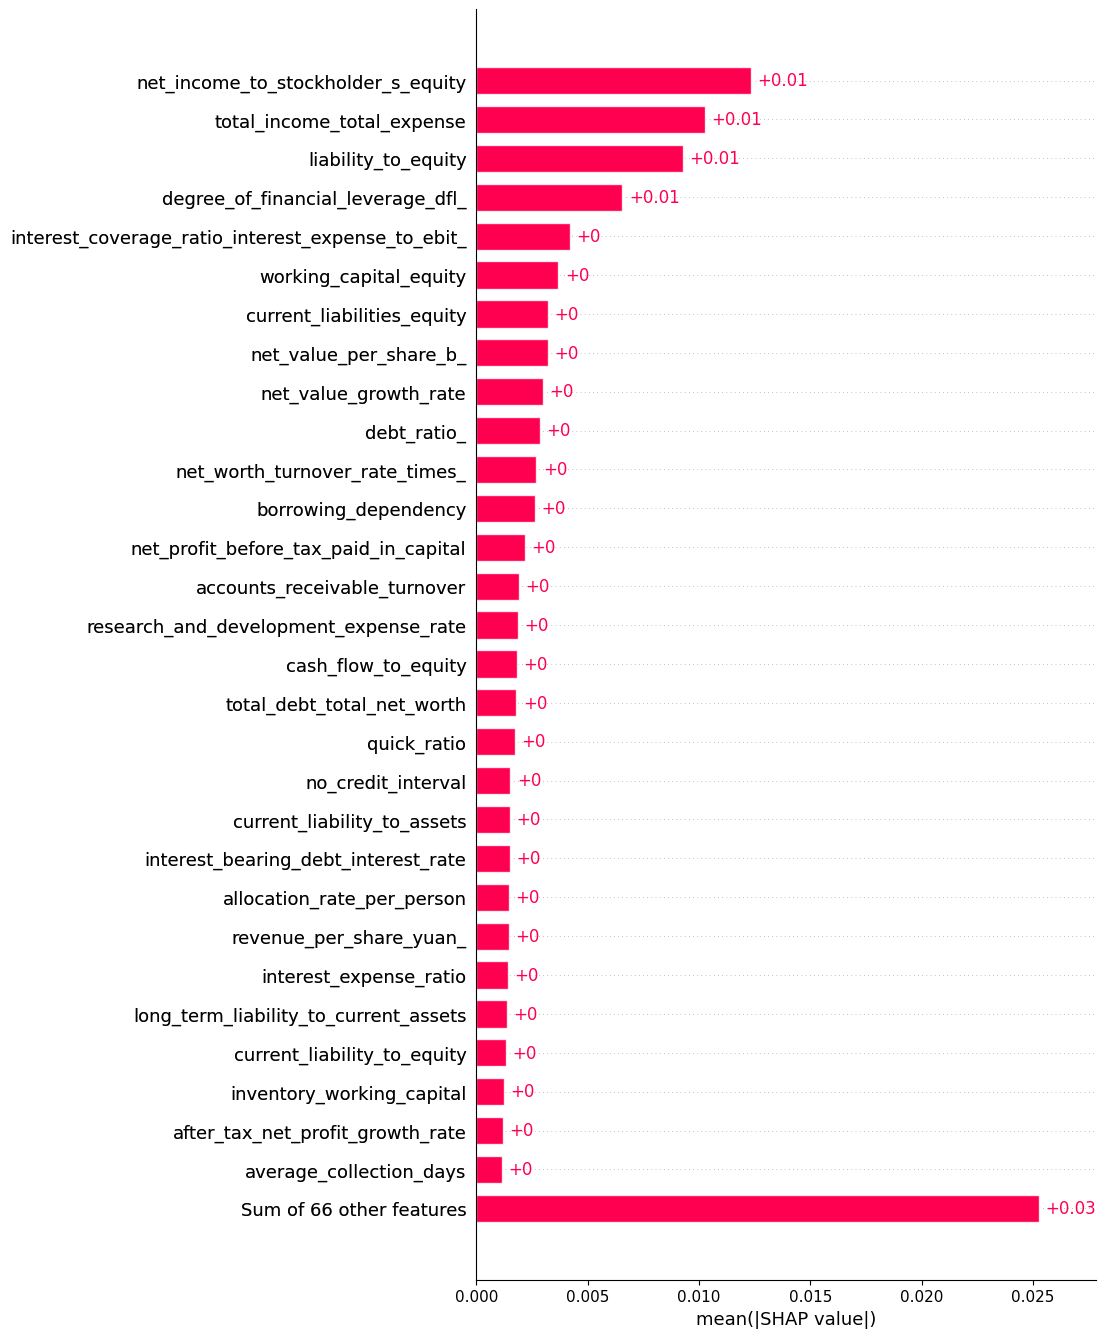

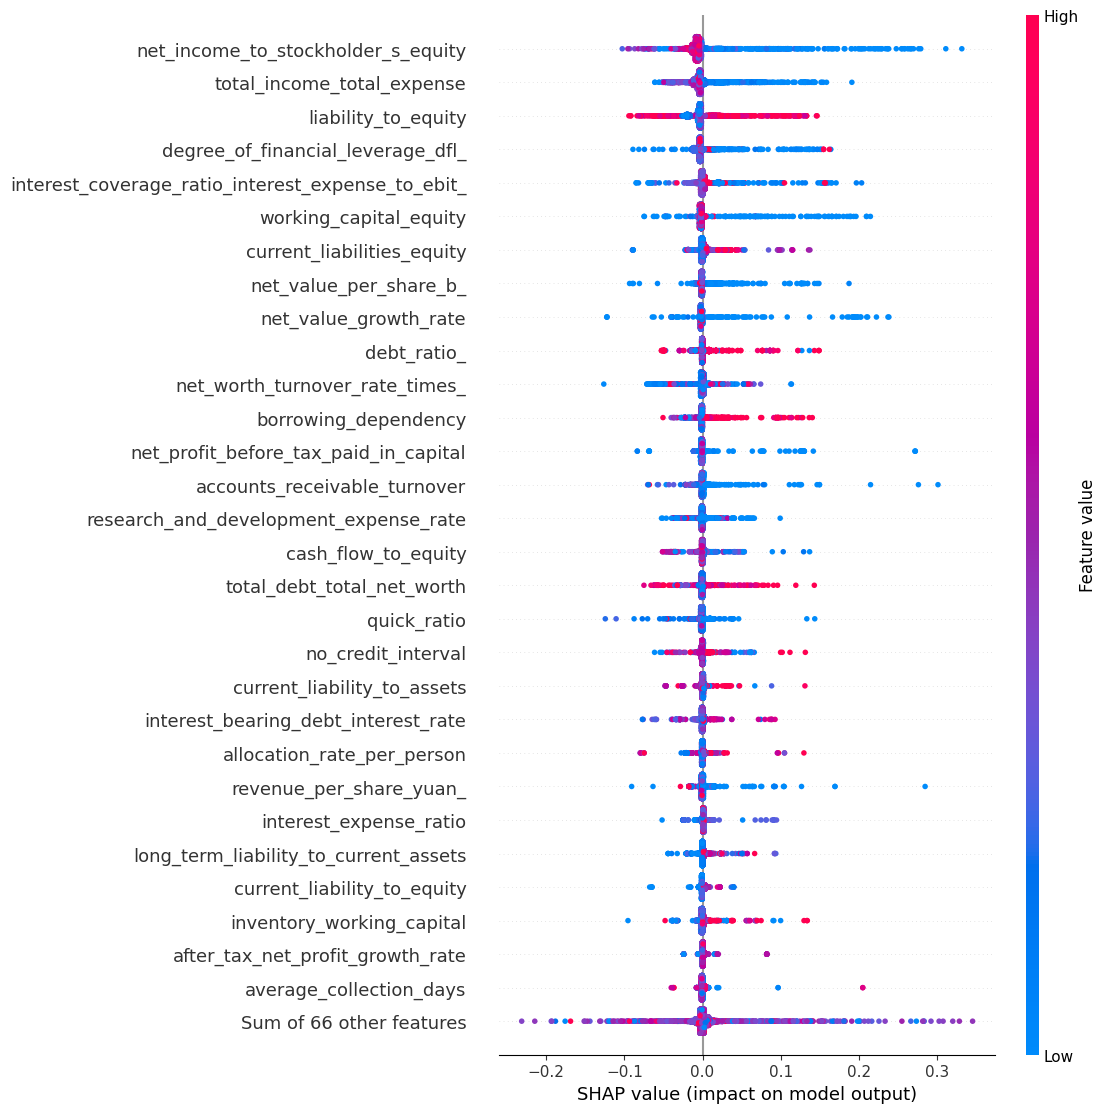

In [49]:
# Fitting SHAP to RF classifier
# ---------------------------------
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_train)

sv = shap_values[:,:,1]  # Pick the SHAP values for the positive class
sv_plot = sv.reshape(sv.shape[0], sv.shape[1])  # Ensure shape is (n_samples, n_features)
base = explainer.expected_value[1]  # Base value for the positive class

# Build Explanation object (include feature names from X_train)
expl = shap.Explanation(values=sv_plot, base_values=base, data=X_train, feature_names=list(X_train.columns))

# Visualization
shap.plots.bar(expl, max_display=10)
shap.plots.beeswarm(expl, max_display=10)

9026it [04:33, 32.00it/s]                                                                                              


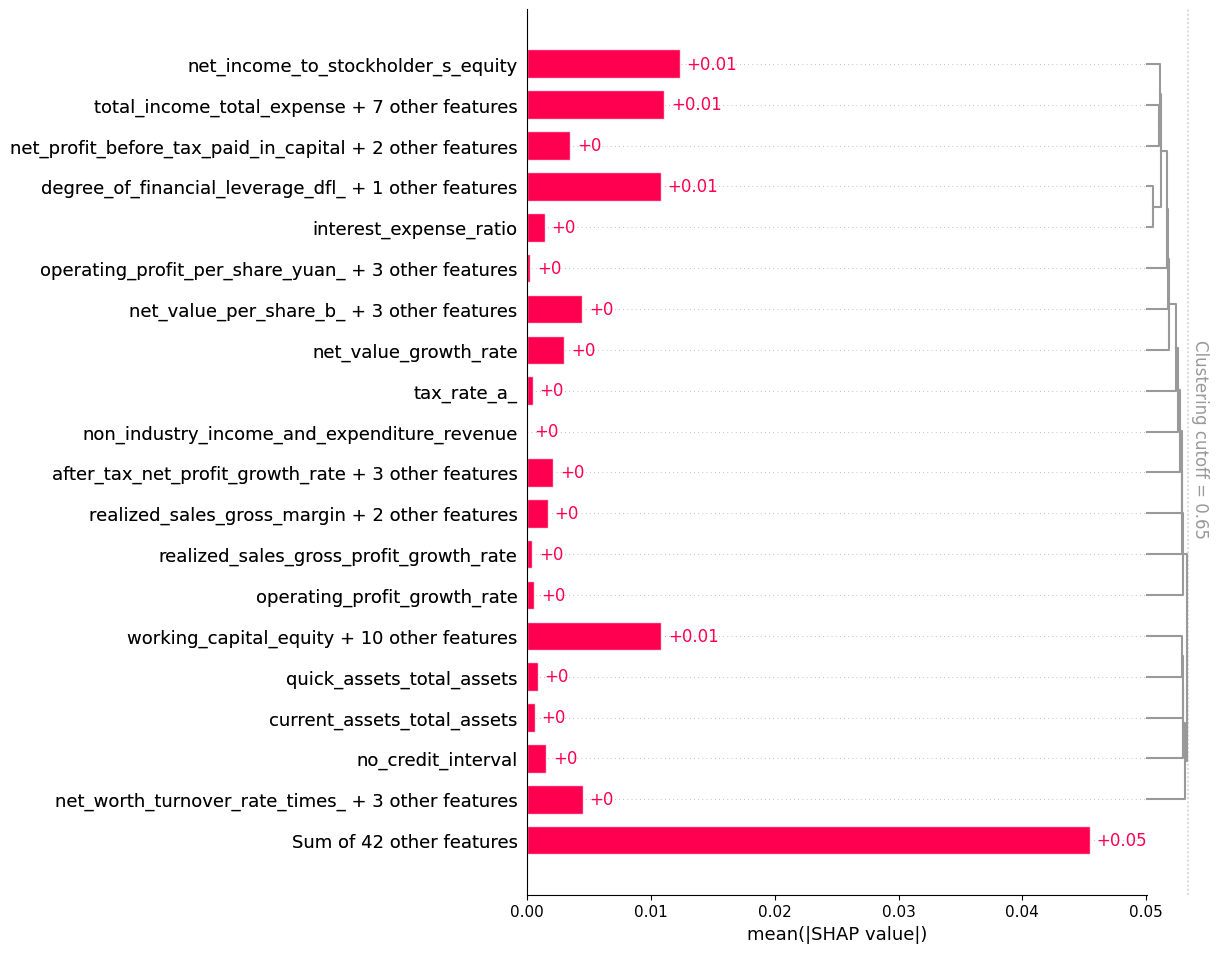

In [56]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(expl, clustering=clustering, clustering_cutoff=.65, max_display=20)

(6819, 7) (6819,)
(5455, 7) (1364, 7) (5455,) (1364,)
Train accuracy: 0.798
Test accuracy: 0.790

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1313
           1       0.12      0.76      0.21        51

    accuracy                           0.79      1364
   macro avg       0.56      0.78      0.55      1364
weighted avg       0.96      0.79      0.85      1364



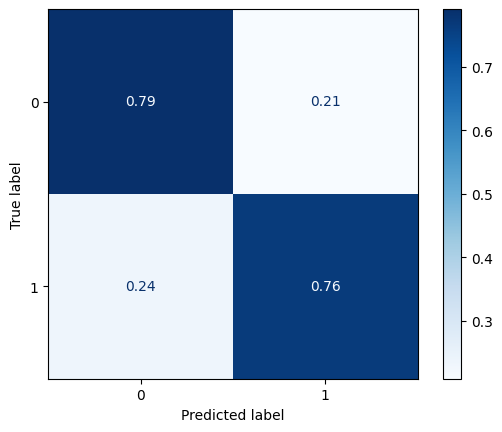

In [59]:
# reduced_df_cols = ['bankrupt_', 
#                    'net_income_to_stockholder_s_equity', 
#                    'working_capital_equity', 'liability_to_equity', 
#                    'cash_flow_to_equity', 
#                    'long_term_liability_to_current_assets']  # Feature clustering on .75 clustering cutoff

reduced_df_cols = ['bankrupt_', 
                   'net_income_to_stockholder_s_equity', 
                   'total_income_total_expense', 
                   'net_profit_before_tax_paid_in_capital', 
                   'degree_of_financial_leverage_dfl_', 
                   'net_value_per_share_b_', 
                   'working_capital_equity', 
                   'net_worth_turnover_rate_times_']  # Feature clustering on .65 clustering cutoff
reduced_df = df[reduced_df_cols]
# reduced_df = df

X = reduced_df.loc[:, reduced_df.columns != 'bankrupt_']  # Selecting all non-sparse features
y = reduced_df['bankrupt_']  # Target is bankruptcy after given time period
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# model = MLPClassifier(hidden_layer_sizes=(128,64,32))
# model = SVC(kernel='poly')
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

print(f"Train accuracy: {model.score(X_train, y_train):.3f}")
print(f"Test accuracy: {model.score(X_test, y_test):.3f}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize by row (divide each row by the sum of that row)
cm_rates = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rates, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='.2f')  # show rates with 2 decimal places

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

## Analysis
Because of the heavily skewed nature of our dataset, (only 51 out of 1364 companies in the set actually bankrupted) it is very difficult to have a balanced classifier on this data. The SHAP analysis helped determine the most relevant data to classify the positive class, i.e. bankrupting companies, which makes the model on the reduced dataset have a high recall but very low precision. This means that it gets most of the positive class companies, but also identifies many false positives. 

This makes it a bad classifier for separating bankrupt vs. non-bankrupting companies. But at the very least, since it catches most of the true positives, it can be a good first step detector algorithm, which governments can use to put big companies at risk of failing on their radar. Further metrics can then be analyzed, ones that we don't have access to, and ultimately achieve the goal we set out for.